In this file, we edit the data of all the managers to also include 
a birth year, by web scraping with Wikidata. After completing this, we will be able to combine
this with the other dataframe and get the birth year of a manager for each ejection. Wikidata is finicky,
so we need to do a small part of this by ourselves.

In [1]:
import pandas as pd
import numpy as np
import wptools

managers = pd.read_csv('../raw_data/List_of_all_managers.csv')
managers

,Manager,Seasons,G,Team,Wins,Losses
0,Scott Servais,2016–,"1,194",SEA,NaN,NaN
1,Lloyd McClendon,2014–2015,324,SEA,NaN,NaN
2,Eric Wedge,2011–2013,486,SEA,NaN,NaN
3,Daren Brown,2010,50,SEA,NaN,NaN
4,Don Wakamatsu,2009–2010,274,SEA,NaN,NaN
...,...,...,...,...,...,...
220,Ryne Sandberg†,2013–2015,278,PHI,119,159
221,Charlie Manuel§,2005–2013,1416,PHI,780,636
222,Gary Varsho,2004,2,PHI,1,1
223,Larry Bowa§[b],2001–2004,645,PHI,337,308


In [2]:
managers = managers.drop(columns = ['Wins', 'Losses'])
managers = managers.rename(columns = {"G": "Games", "Manager": "Name"})
managers

,Name,Seasons,Games,Team
0,Scott Servais,2016–,"1,194",SEA
1,Lloyd McClendon,2014–2015,324,SEA
2,Eric Wedge,2011–2013,486,SEA
3,Daren Brown,2010,50,SEA
4,Don Wakamatsu,2009–2010,274,SEA
...,...,...,...,...
220,Ryne Sandberg†,2013–2015,278,PHI
221,Charlie Manuel§,2005–2013,1416,PHI
222,Gary Varsho,2004,2,PHI
223,Larry Bowa§[b],2001–2004,645,PHI


In [3]:
print(managers.describe())
print(managers.dtypes)

              Name Seasons Games Team
count          225     225   225  225
unique         164     133   152   30
top     Bob Melvin    2002   324  MIA
freq             5       6    21   14
Name       object
Seasons    object
Games      object
Team       object
dtype: object


In [4]:
def games_as_int(games):
    '''Convert the comma separated strings of games to an integer'''
    return int(games.replace(',', ''))

managers = managers.assign(Games = managers.get('Games').apply(games_as_int))

In [5]:
def strip_symbols(manager_name): 
    '''Get rid of Wikipedia's symbols at the end of managers' names'''
    return manager_name.replace('[b]', '').replace('[c]', '').replace('[d]', '').replace('[e]', '').replace('(interim)', '').strip('*‡†§ ').strip()

managers = managers.assign(Name = managers.get('Name').apply(strip_symbols))

In [6]:
def get_year_from_timestamp(birth_timestamp: str):
    ''''''
    if (type(birth_timestamp) is list): # Multiple timestamps found
        birth_timestamp = birth_timestamp[-1] # Use last one, it is the accurate timestamp in the two cases.
    birth_timestamp = birth_timestamp.strip('+') # Get rid of starting +
    return int(str.split(birth_timestamp, '-')[0])

def get_manager_birth_year(manager_name: str):
    '''Gets managers birth year from online lookup. Works for most manager names, but does not work for some.
    If multiple people have same name, function crashes seeing a disambiguation page. Returns None in those scenarios.
    Otherwise, returns the year that a manager was born. Function takes about 1.5 seconds per entry.'''
    try:
        manager_page = wptools.page(manager_name, silent = True) # Gets the page with wikidata without outputting to cout
    except LookupError:
        print(f"Could not locate manager {manager_name}'s wikipedia page")
        return None
    # Get information from the correct key-value pair: wikidata, date of birth are dictionaries
    try:
        manager_birth_timestamp = (manager_page.get().data['wikidata']['date of birth (P569)'])
    except ValueError:
        print(f"Could not locate manager {manager_name}'s date of birth. Resolve manually!")
        return None
    return get_year_from_timestamp(manager_birth_timestamp)

# Test
assert(get_manager_birth_year('Scott Servais') == 1967)

In [7]:
# These are the names to resolve managers to be
managers = managers.assign(wiki_names = managers.get('Name'))

In [8]:
# Rename all names that link to get disambiguation pages to the accurate page. 
# This is necessary, otherwise the library would not be able to resolve the specific names.
managers.loc[6, 'wiki_names'] = 'John McLaren (baseball)'
managers.loc[31, 'wiki_names'] = 'Brad Mills (manager)'
managers.loc[32, 'wiki_names'] = 'Dave Clark (baseball)'
managers.loc[75, 'wiki_names'] = 'Tom Kelly (baseball)'
managers.loc[82, 'wiki_names'] = 'John Farrell (manager)'
managers.loc[88, 'wiki_names'] = 'John Schneider (baseball)'
managers.loc[91, 'wiki_names'] = 'John Farrell (manager)'
managers.loc[115, 'wiki_names'] = 'Dave Roberts (baseball manager)'
managers.loc[119, 'wiki_names'] = 'Jim Tracy (baseball)'
managers.loc[125, 'wiki_names'] = 'Andy Green (baseball)'
managers.loc[126, 'wiki_names'] = 'Dave Roberts (baseball manager)'
managers.loc[127, 'wiki_names'] = 'Pat Murphy (baseball coach)'
managers.loc[132, 'wiki_names'] = 'Jim Tracy (baseball)'
managers.loc[144, 'wiki_names'] = 'David Bell (baseball)'
managers.loc[154, 'wiki_names'] = 'David Ross (baseball)'
managers.loc[177, 'wiki_names'] = 'John Russell (catcher)'
managers.loc[178, 'wiki_names'] = 'Jim Tracy (baseball)'
managers.loc[186, 'wiki_names'] = 'Dan Jennings (manager)'
managers.loc[192, 'wiki_names'] = 'Edwin Rodríguez (baseball)'
managers.loc[198, 'wiki_names'] = 'John Boles (baseball)'
managers.loc[199, 'wiki_names'] = 'Carlos Mendoza (baseball coach)'
managers.loc[201, 'wiki_names'] = 'Luis Rojas (baseball)'
managers.loc[210, 'wiki_names'] = 'Matt Williams (third baseman)'
managers.loc[212, 'wiki_names'] = 'John McLaren (baseball)'

In [9]:
managers = managers.assign(birth_year = managers.get('wiki_names').apply(get_manager_birth_year))
managers

Could not locate manager Mike Hargrove's date of birth. Resolve manually!
Could not locate manager Sandy Alomar Jr.'s date of birth. Resolve manually!
Could not locate manager Ozzie Guillén's date of birth. Resolve manually!
Could not locate manager Juan Samuel's date of birth. Resolve manually!
Could not locate manager Mike Hargrove's date of birth. Resolve manually!
Could not locate manager David Bell (baseball)'s date of birth. Resolve manually!
Could not locate manager Ozzie Guillén's date of birth. Resolve manually!


,Name,Seasons,Games,Team,wiki_names,birth_year
0,Scott Servais,2016–,1194,SEA,Scott Servais,1967.0
1,Lloyd McClendon,2014–2015,324,SEA,Lloyd McClendon,1959.0
2,Eric Wedge,2011–2013,486,SEA,Eric Wedge,1968.0
3,Daren Brown,2010,50,SEA,Daren Brown,1967.0
4,Don Wakamatsu,2009–2010,274,SEA,Don Wakamatsu,1963.0
...,...,...,...,...,...,...
220,Ryne Sandberg,2013–2015,278,PHI,Ryne Sandberg,1959.0
221,Charlie Manuel,2005–2013,1416,PHI,Charlie Manuel,1944.0
222,Gary Varsho,2004,2,PHI,Gary Varsho,1961.0
223,Larry Bowa,2001–2004,645,PHI,Larry Bowa,1945.0


In [11]:
managers[managers.get('birth_year').isnull()]

,Name,Seasons,Games,Team,wiki_names,birth_year
7,Mike Hargrove,2005–2007,402,SEA,Mike Hargrove,NaN
43,Sandy Alomar Jr.,2012,6,CLE,Sandy Alomar Jr.,NaN
53,Ozzie Guillén,2004–2011,1295,CHW,Ozzie Guillén,NaN
99,Juan Samuel,2010,51,BAL,Juan Samuel,NaN
103,Mike Hargrove,2000–2003,647,BAL,Mike Hargrove,NaN
144,David Bell,2019–present,708,CIN,David Bell (baseball),NaN
188,Ozzie Guillén,2012,162,MIA,Ozzie Guillén,NaN


In [12]:
# Manually fix values which Wikidata cannot resolve
managers.loc[7, 'birth_year'] = 1949
managers.loc[43, 'birth_year'] = 1966
managers.loc[53, 'birth_year'] = 1964
managers.loc[99, 'birth_year'] = 1964
managers.loc[103, 'birth_year'] = 1949
managers.loc[188, 'birth_year'] = 1964

In [13]:
# We're finally read
managers = managers.assign(birth_year = managers.get('birth_year').apply(int))
managers

ValueError: cannot convert float NaN to integer

In [ ]:
managers = managers.rename(columns = {"birth_year": "Birth_Year", "wiki_names": "Wiki_Names"})

Let's see if these date of birth values make sense by making I few plots. If they don't, I likely made an error in my script.

In [ ]:
sorted_managers = managers.sort_values(by = 'Birth_Year', ascending = True).get(['Name', 'Birth_Year'])
min_birth = sorted_managers.iloc[0].get('Birth_Year')
min_birth_person = sorted_managers.iloc[0].get('Name')
max_birth = sorted_managers.iloc[-1].get('Birth_Year')
max_birth_person = sorted_managers.iloc[-1].get('Name')
print(f"Earliest birth year is {min_birth_person} in {min_birth}. Latest birth is {max_birth_person} in {max_birth}")

Earliest birth year is Jack McKeon in 1930. Latest birth is Kai Correa in 1988


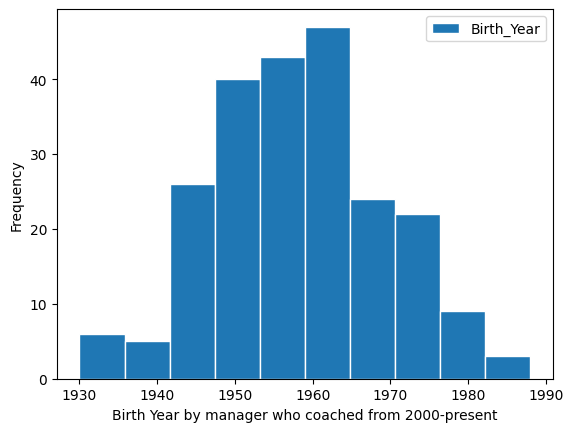

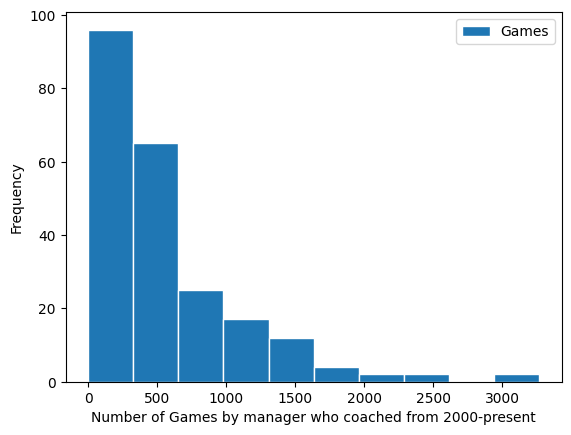

In [ ]:
import matplotlib.pyplot as plt
managers.plot(kind = 'hist', y = 'Birth_Year', ec = 'w', xlabel = 'Birth Year by manager who coached from 2000-present');
managers.plot(kind = 'hist', y = 'Games', ec = 'w', xlabel = 'Number of Games by manager who coached from 2000-present');

In [ ]:
csv_data = managers.to_csv(index = False)
file_path = '../created_data/managers_with_birth.csv'
with open(file_path, 'w') as f:
    f.write(csv_data)
